## Import Libs

In [90]:
# import os
import pandas as pd
import numpy as np
import datetime as dt
import logging
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from torch import optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from torch.optim import AdamW
from utils import SklearnWrapper

In [2]:
from config import *
from entities import *
from components import *
from strategies import *
from datasets import *
from engine import Engine
from models import DiffusionTransformer
from frameworks import Diffusion

## Setting 

In [3]:
# logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

## Data

### Load Data to basket

In [4]:
symbols = ['AAPL', 'TSLA', 'MSFT']
basket = Basket(symbols=symbols)
basket.load_all_assets(freq="1d")

### Norm To Returns

In [5]:
targets = ["Close", "High"]
for symbol, asset in basket.assets.items():
    asset.to_returns(log=True, columns=targets)
asset.data.head(5)

,Low,Open,Volume,Close (Log_Returns),High (Log_Returns)
Date,,,,,
2015-01-05,39.497520,39.599999,39673900,-0.009238,-0.014658
2015-01-06,38.891163,39.608523,36447900,-0.014787,0.000427
2015-01-07,38.848476,39.266934,29114100,0.012626,-0.006222
2015-01-08,39.898901,39.924520,29645200,0.028994,0.027387
2015-01-09,40.052616,40.658956,23944200,-0.008441,0.001465


### Align Data (Joint Data)

In [6]:
strategy = IntersectionStrategy()
joint_df = basket.align(strategy)
joint_df.head()

AAPL                                            \
                  Low       Open     Volume Close (Log_Returns)   
Date                                                              
2015-01-05  23.391173  24.030263  257142000           -0.028576   
2015-01-06  23.218085  23.641928  263188400            0.000094   
2015-01-07  23.677430  23.788384  160423600            0.013925   
2015-01-08  24.121236  24.238848  237458000            0.037702   
2015-01-09  24.456320  25.002210  214798000            0.001072   

                                    TSLA                       \
           High (Log_Returns)        Low       Open    Volume   
Date                                                            
2015-01-05          -0.025355  13.810667  14.303333  80527500   
2015-01-06          -0.011292  13.614000  14.004000  93928500   
2015-01-07           0.007142  13.985333  14.223333  44526000   
2015-01-08           0.035856  14.000667  14.187333  51637500   
2015-01-09           0.009761  13.664000  13.928000  70024500   

                                                        MSFT             \
           Close (Log_Returns) High (Log_Returns)        Low       Open   
Date                                                                      
2015-01-05           -0.042950          -0.030702  39.497520  39.599999   
2015-01-06            0.005648          -0.010680  38.891163  39.608523   
2015-01-07           -0.001563           0.002704  38.848476  39.266934   
2015-01-08           -0.001566          -0.004573  39.898901  39.924520   
2015-01-09           -0.018981          -0.018029  40.052616  40.658956   

                                                             
              Volume Close (Log_Returns) High (Log_Returns)  
Date                                                         
2015-01-05  39673900           -0.009238          -0.014658  
2015-01-06  36447900           -0.014787           0.000427  
2015-01-07  29114100            0.012626          -0.006222  
2015-01-08  29645200            0.028994           0.027387  
2015-01-09  23944200           -0.008441           0.001465

In [7]:
features = ["Close (Log_Returns)", "High (Log_Returns)"]
basket_tensor = basket.to_tensor(features=features)
basket_tensor.shape

torch.Size([2723, 3, 2])

#### Market Setup & Window Rolling Setup

In [8]:
window = RollingWindow(size=64, stride=1)
market = Market(basket, window)
market_tensor = market.setup(features=features)

In [9]:
market_tensor.shape

torch.Size([2660, 64, 3, 2])

### Scaler

In [10]:
sklearn_scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = SklearnWrapper(sklearn_scaler)

scaler.fit(market_tensor)
norm_data = scaler.encode(market_tensor)

print(f"Norm data shape: {market_tensor.shape}")
print(f"Data {market_tensor[0,0,0,:]}")

Norm data shape: torch.Size([2660, 64, 3, 2])
Data tensor([-0.0286, -0.0254], device='cuda:0')


### Dataloader & Datasets

In [11]:
modes = ["exhaustive", "random"]
market_ds = JointMarketDataset(norm_data)
# market_ds = MarketDataset(norm_data, mode='random')
ratios = [0.8, 0.1, 0.1]
train_ds, val_ds, test_ds = create_randomize_datasets(market_ds, ratios)

print(f"Train samples: {len(train_ds)}")
print(f"Val samples: {len(val_ds)}") 
print(f"Test samples: {len(test_ds)}")

Train samples: 2128
Val samples: 266
Test samples: 266


In [12]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

In [13]:
x = next(iter(train_loader))
x.shape

torch.Size([32, 64, 3, 2])

## Model

### Setup

In [14]:
cfg = TrainConfig(
    epochs=500,
    optimizer=OptimizerConfig(lr=2e-4)
)

print(cfg.optimizer.lr) 
print(cfg.epochs)    

0.0002
500


In [15]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 50
BATCH_SIZE = 32
LR = 1e-4

WINDOW_SIZE = x.shape[1]       # Length (L)
NUM_ASSETS = x.shape[2]         # N (จำนวนหุ้น)
NUM_FEATURES = x.shape[3]      # F (OHLCV...)
TOTAL_INPUT_DIM = NUM_ASSETS * NUM_FEATURES # C = N * F (Flatten แล้ว)

print(f"Running on: {DEVICE}")
print(f"Input Dimension (Channels): {TOTAL_INPUT_DIM}")

Running on: cuda
Input Dimension (Channels): 6


### Diffusion

In [16]:
diffusion = Diffusion(
    noise_steps=1000,
    beta_start=1e-4,
    beta_end=0.02,
    schedule="cosine", # แนะนำ Cosine สำหรับ Time Series
    device=DEVICE
)

### NN Model

In [17]:
model = DiffusionTransformer(
    features_in=TOTAL_INPUT_DIM,  # รับ Input ขนาด N*F
    d_model=128,                  # ความกว้าง Model
    nhead=4,
    num_layers=4,
    max_len=WINDOW_SIZE           # รองรับความยาวสูงสุดเท่า Window
).to(DEVICE)

/home/narodom.y@FUSION.LAB/.conda/envs/tsgenai/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


### Optimizer

In [18]:
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-6)

## Engine

In [19]:
engine = Engine(
    model=model,
    diffusion=diffusion,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    device=DEVICE,
    scaler=scaler
)

### Training

In [20]:
engine.fit(epochs=EPOCHS, save_dir="./checkpoints")

Epoch 50/50: 100%|██████████| 67/67 [00:02<00:00, 26.35it/s, loss=0.0266]


### Test

In [21]:
x_test = next(iter(test_loader))
x_test.shape

torch.Size([32, 64, 3, 2])

In [22]:
prediction = engine.simulate(x_test, steps_to_predict=8)
prediction.shape

In-painting: 1000it [00:11, 85.84it/s]


(32, 64, 3, 2)

## Monte Carlo Sim (GenAI)

In [23]:
@torch.no_grad()
def monte_carlo_simulate(context_data, steps_to_simulate, engine,num_simulations=100):
    x_context = context_data.repeat(num_simulations, 1, 1, 1).to(engine.device)
    mc_results = engine.simulate(x_context, steps_to_simulate)
    return mc_results

In [24]:
x_test_sampling = x_test[0].unsqueeze(0)
x_test_sampling.shape

torch.Size([1, 64, 3, 2])

In [26]:
mc_y = monte_carlo_simulate(context_data=x_test_sampling, steps_to_simulate=24, engine=engine,num_simulations=100)
mc_y.shape # [Sims, Time, Assets, Features]

In-painting: 1000it [00:33, 30.26it/s]


(100, 64, 3, 2)

## Monete Carlo Statistic

In [61]:
def gbm_monte_carlo_simulate(hist_log_returns: np.ndarray, steps_to_predict: int, num_sims: int = 100, dt: float = 1.0):
    """ Arg: 
            dt: Time increment
        Returns: 
            future_prices: [num_sims, steps_to_predict]
    """
    mu = np.mean(hist_log_returns)
    sigma = np.std(hist_log_returns)

    # Random Shock (Z) from Normal Dist (0, 1) -> shape: [num_sims, steps_to_predict]
    Z = np.random.normal(0, 1, (num_sims, steps_to_predict))

    # Future log returns (GBM)
    # r_t = (mu - 0.5 * sigma^2) * dt + sigma * sqrt(dt) * Z
    drift_term = (mu - 0.5 * sigma**2) * dt
    shock_term = sigma * np.sqrt(dt) * Z

    future_daily_log_returns = drift_term + shock_term
    cum_log_returns = np.cumsum(future_daily_log_returns, axis=1)

    # future_prices = last_price * np.exp(cum_log_returns)
    
    return future_daily_log_returns

In [62]:
x_test_sampling.shape

torch.Size([1, 64, 3, 2])

In [63]:
x_test_statistic_sampling = x_test_sampling[0,:,:,:]
x_test_statistic_sampling.shape

torch.Size([64, 3, 2])

In [64]:
x_test_statistic_sampling = x_test_statistic_sampling[:,0,0]
x_test_statistic_sampling.shape

torch.Size([64])

In [65]:
type(x_test_statistic_sampling)

torch.Tensor

In [66]:
mc_paths = gbm_monte_carlo_simulate(
    hist_log_returns=x_test_statistic_sampling.cpu().numpy(), 
    steps_to_predict=14, 
    num_sims=1000
)
type(mc_paths)

numpy.ndarray

In [69]:
asset_tests = x_test_sampling[0, :,:, :]
asset_tests.shape

torch.Size([64, 3, 2])

In [70]:
asset_tests = asset_tests.permute(1,0,2)
asset_tests.shape

torch.Size([3, 64, 2])

In [71]:
mc_simed_ret_assets = []
for asset in asset_tests:
    mc_sim_ret = gbm_monte_carlo_simulate(
        hist_log_returns=asset[:, 0].cpu().numpy(), 
        steps_to_predict=14, 
        num_sims=1000
    )
    mc_simed_ret_assets.append(mc_sim_ret)

In [72]:
len(mc_simed_ret_assets)

3

In [87]:
for asset in mc_simed_ret_assets:
    mc_ret_context = asset[:, -1]
    mc_ret_sim = asset[-1, :]

    mean_ret_sim = np.mean(mc_ret_sim)
    std_ret_sim = np.std(mc_ret_sim)
    upper_bound = np.percentile(mc_ret_sim, 95) # Best case 5%
    lower_bound = np.percentile(mc_ret_sim, 5) # Worst case 5%
    print(f"mean: {mean_ret_sim}, std: {std_ret_sim}")
    print(f"lower bound: {lower_bound}, upper bound:{upper_bound}")

mean: 0.0848917434740952, std: 0.052414608635948406
lower bound: 0.010011157922048423, upper bound:0.16943751510663657
mean: 0.07383038544548427, std: 0.13980833261645825
lower bound: -0.15660817677995015, upper bound:0.23750845187833128
mean: 0.07520682918198278, std: 0.03403643978481935
lower bound: 0.03094408201329238, upper bound:0.13191800722947453


Correlation Matrix:
[[ 1.         -0.04302821 -0.00214342]
 [-0.04302821  1.          0.01788894]
 [-0.00214342  0.01788894  1.        ]]


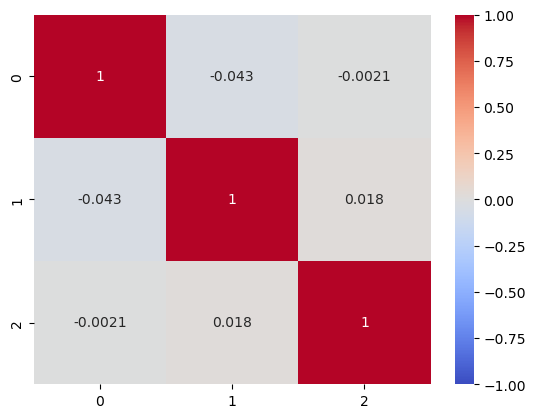

In [91]:
sim_results_per_asset = []

for asset_sim in mc_simed_ret_assets:
    # asset_sim shape: (1000, 14) -> Daily Log Returns
    
    # รวม Log Return 14 วัน เป็นก้อนเดียว (Total Log Return)
    # axis=1 คือรวมตามแกนเวลา (Time)
    total_return = np.sum(asset_sim, axis=1) # ได้ shape (1000,)
    
    sim_results_per_asset.append(total_return)

# 2. แปลงเป็น Matrix (Num_Assets, Num_Sims)
# เช่น (3, 1000)
comparison_matrix = np.array(sim_results_per_asset)

# 3. คำนวณ Correlation Matrix
corr_matrix = np.corrcoef(comparison_matrix)

print("Correlation Matrix:")
print(corr_matrix)

# (แถม) วาด Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()